# Multiple overlays

We have focused on data exploration on single dataframes, geared to create map visualizations for individual layers. This lab goes over *overlays*, creating a single map that has multiple layers of data.

Research inquiry: Which neighborhoods in Los Angeles have the highest instances of arrests?

In [1]:
import geopandas as gpd

In [2]:
# get neighborhood boundaries from the LA Times
neighborhoods = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson')

In [3]:
# trim the data to the bare minimum columns
neighborhoods = neighborhoods[['name','geometry']]

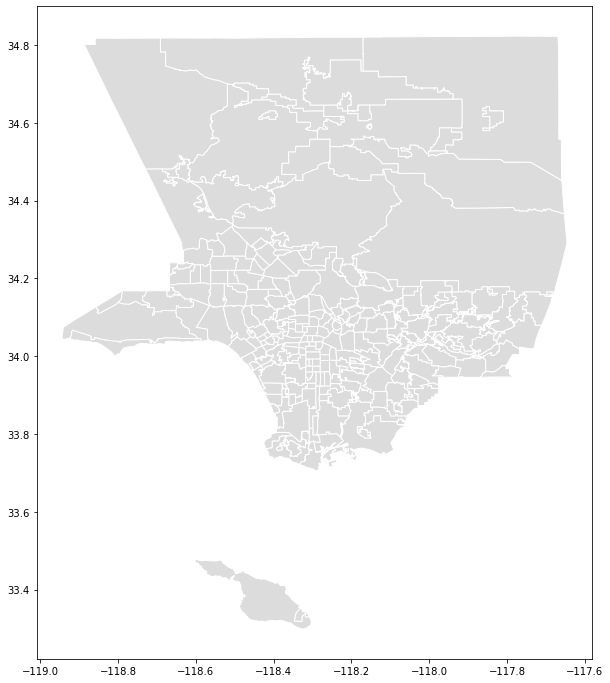

In [4]:
ax=neighborhoods.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax.set_aspect('equal')

### Creating a socrata client
Next, we acquire the data using the socrata API. Use the socrata documentation to grab the code syntax for our crime data.
- https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72

In [5]:
import pandas as pd
import plotly.express as px
from sodapy import Socrata

In [6]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("amvf-fr72", 
                     limit=2000,
                     where = "arst_date between '2020-09-01T00:00:00' and '2020-09-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
df = pd.DataFrame.from_records(results)

# print it with .sample, which gives you random rows
df.head()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,dispo_desc,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst
0,6019649,BOOKING,2020-09-26T00:00:00.000,1340,02,Rampart,0269,29,M,B,...,MISDEMEANOR COMPLAINT FILED,1200 W 7TH ST,34.0515,-118.2658,"{'type': 'Point', 'coordinates': [-118.2658, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,NaN
1,6019527,BOOKING,2020-09-26T00:00:00.000,0615,14,Pacific,1494,26,M,B,...,NaN,400 WORLD WAY WY,33.942,-118.4095,"{'type': 'Point', 'coordinates': [-118.4095, 3...",2020-09-26T00:00:00.000,0819,PACIFIC,4214,NaN
2,6019650,BOOKING,2020-09-26T00:00:00.000,1250,07,Wilshire,0702,53,M,W,...,NaN,SIERRA BONITA,34.0837,-118.3543,"{'type': 'Point', 'coordinates': [-118.3543, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,MELROSE
3,6019578,BOOKING,2020-09-26T00:00:00.000,0920,15,N Hollywood,1531,41,M,H,...,MISDEMEANOR COMPLAINT FILED,WHITSETT,34.1758,-118.4052,"{'type': 'Point', 'coordinates': [-118.4052, 3...",2020-09-26T00:00:00.000,1120,VALLEY - JAIL DIV,4279,HATTERAS
4,6019399,BOOKING,2020-09-26T00:00:00.000,0105,01,Central,0163,19,M,W,...,MISDEMEANOR COMPLAINT FILED,9TH,34.043,-118.2571,"{'type': 'Point', 'coordinates': [-118.2571, 3...",2020-09-26T00:00:00.000,0225,METRO - JAIL DIVISION,4273,HILL


In [7]:
list(df)

['rpt_id',
 'report_type',
 'arst_date',
 'time',
 'area',
 'area_desc',
 'rd',
 'age',
 'sex_cd',
 'descent_cd',
 'chrg_grp_cd',
 'grp_description',
 'arst_typ_cd',
 'charge',
 'chrg_desc',
 'dispo_desc',
 'location',
 'lat',
 'lon',
 'location_1',
 'bkg_date',
 'bkg_time',
 'bgk_location',
 'bkg_loc_cd',
 'crsst']

In [8]:
# convert pandas dataframe to geodataframe
crime = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

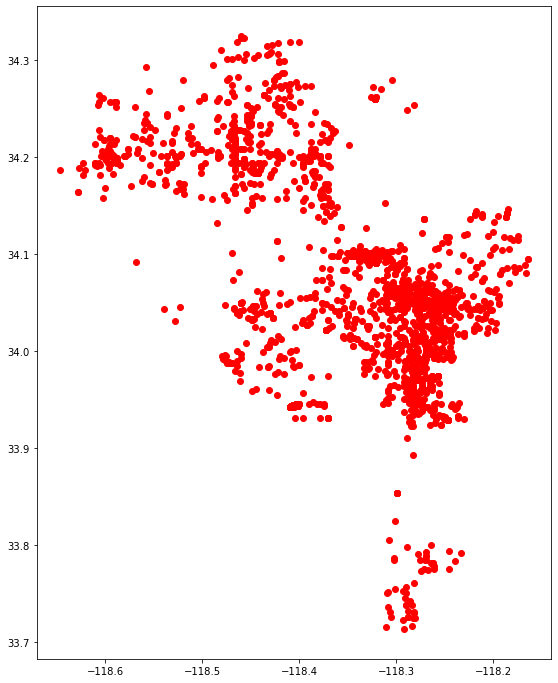

In [9]:
crime.plot(figsize=(12,12),color='red')

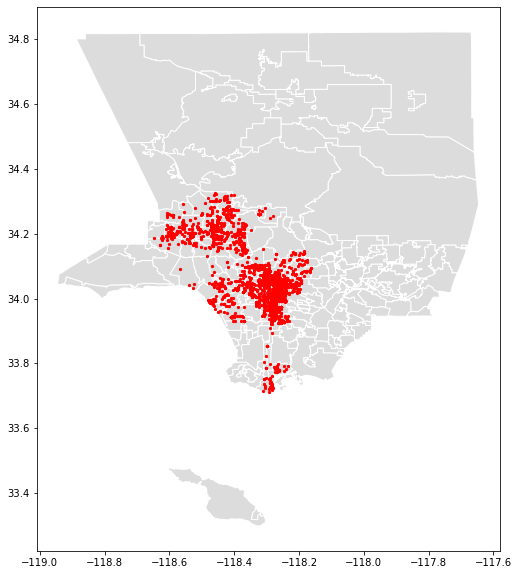

In [10]:
base = neighborhoods.plot(figsize=(12,10),color='gainsboro', edgecolor='white')
ax.set_aspect('equal')
ax = crime.plot(ax=base, marker='o', color='red', markersize=5)

## zoom to the points, not the neighborhoods

In [11]:
minx, miny, maxx, maxy = crime.geometry.total_bounds

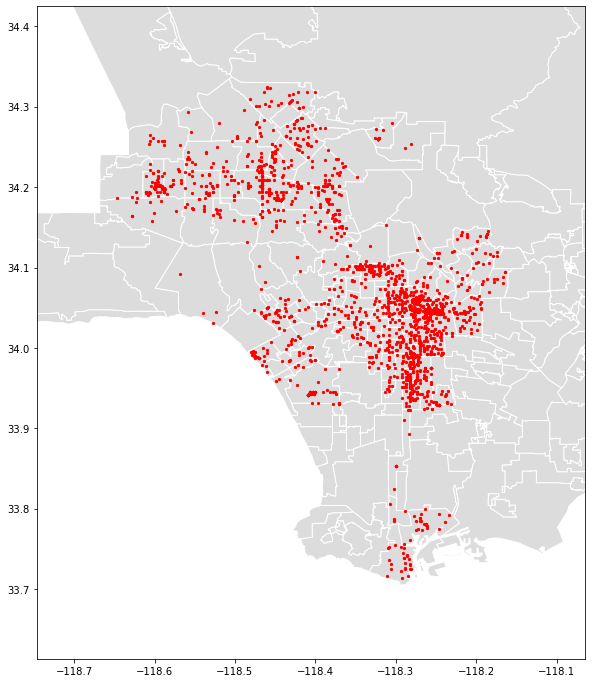

In [12]:
base = neighborhoods.plot(figsize=(12,12),color='gainsboro', edgecolor='white')
ax = crime.plot(ax=base, marker='o', color='red', markersize=5)
ax.set_xlim(minx - .1, maxx + .1) # added/substracted value is to give some margin around total bounds
ax.set_ylim(miny - .1, maxy + .1)
ax

In [13]:
type(crime)

geopandas.geodataframe.GeoDataFrame

In [14]:
crime.set_crs(epsg=4326, inplace=True)
crime.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
join = gpd.sjoin(neighborhoods,crime,how='right')

In [16]:
join.head()

,index_left,name,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
1159,1.0,Adams-Normandie,6014888,BOOKING,2020-09-18T00:00:00.000,2200,03,Southwest,0325,47,...,27TH ST,34.0305,-118.2915,"{'type': 'Point', 'coordinates': [-118.2915, 3...",2020-09-19T00:00:00.000,0056,77TH ST,4212,VERMONT AV,POINT (-118.29150 34.03050)
1159,232.0,University Park,6014888,BOOKING,2020-09-18T00:00:00.000,2200,03,Southwest,0325,47,...,27TH ST,34.0305,-118.2915,"{'type': 'Point', 'coordinates': [-118.2915, 3...",2020-09-19T00:00:00.000,0056,77TH ST,4212,VERMONT AV,POINT (-118.29150 34.03050)
561,1.0,Adams-Normandie,6016613,BOOKING,2020-09-21T00:00:00.000,2130,03,Southwest,0325,31,...,NORMANDIE,34.0307,-118.2923,"{'type': 'Point', 'coordinates': [-118.2923, 3...",2020-09-22T00:00:00.000,0132,77TH ST,4212,ADAMS,POINT (-118.29230 34.03070)
505,1.0,Adams-Normandie,6016175,BOOKING,2020-09-21T00:00:00.000,0400,03,Southwest,0326,54,...,2600 BRIGHTON AV,34.0322,-118.3015,"{'type': 'Point', 'coordinates': [-118.3015, 3...",2020-09-21T00:00:00.000,0543,77TH ST,4212,NaN,POINT (-118.30150 34.03220)
1798,1.0,Adams-Normandie,6012234,BOOKING,2020-09-14T00:00:00.000,2210,03,Southwest,0326,32,...,2600 S HARVARD BL,34.0322,-118.3067,"{'type': 'Point', 'coordinates': [-118.3067, 3...",2020-09-15T00:00:00.000,0137,77TH ST,4212,NaN,POINT (-118.30670 34.03220)


In [17]:
crime_by_neighborhoods = join.name.value_counts().rename_axis('name').reset_index(name='crime_count')

In [18]:
crime_by_neighborhoods.head()

,name,crime_count
0,Downtown,155
1,Van Nuys,99
2,Westlake,90
3,Hollywood,85
4,Florence,67


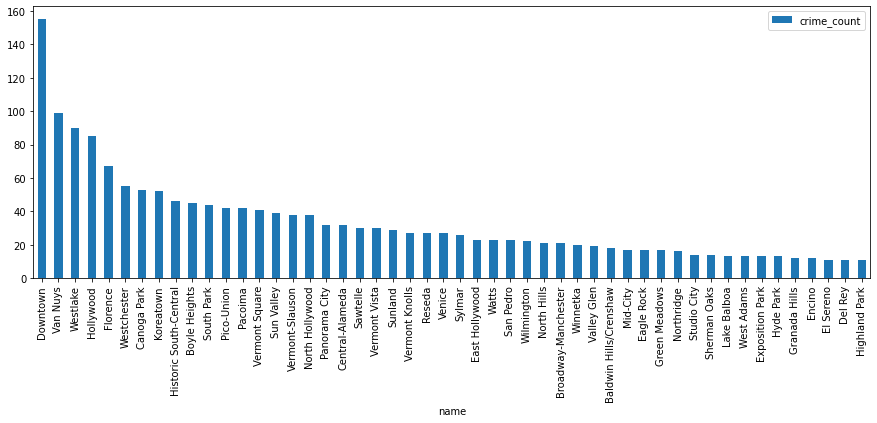

In [19]:
crime_by_neighborhoods[:50].plot.bar(figsize=(15,5),x='name',y='crime_count')

In [20]:
# join the summary table back to the neighborhood geodatabase
neighborhoods=neighborhoods.merge(crime_by_neighborhoods,on='name')


In [21]:
neighborhoods.head()

,name,geometry,crime_count
0,Adams-Normandie,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004...",7
1,Arleta,"MULTIPOLYGON (((-118.42202 34.22410, -118.4228...",4
2,Arlington Heights,"MULTIPOLYGON (((-118.31591 34.05261, -118.3134...",5
3,Atwater Village,"MULTIPOLYGON (((-118.27832 34.15301, -118.2770...",6
4,Baldwin Hills/Crenshaw,"MULTIPOLYGON (((-118.35626 34.02484, -118.3550...",18


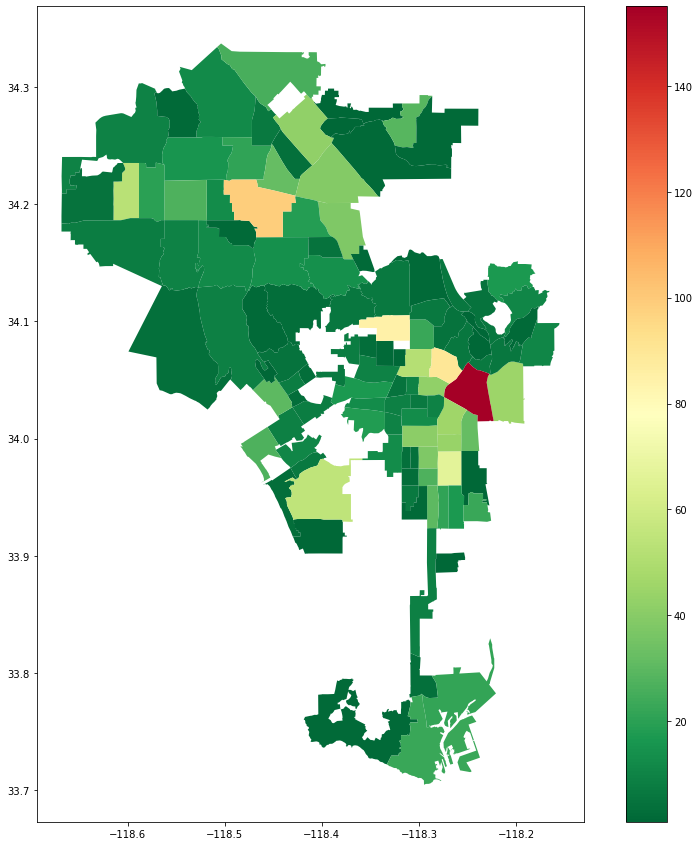

In [22]:
neighborhoods.plot(figsize=(15,15),column='crime_count',legend=True,cmap='RdYlGn_r')

In [23]:
# clean it up

In [24]:
import contextily as ctx

In [25]:
# reproject to web mercator
neighborhoods = neighborhoods.to_crs(epsg=3857)

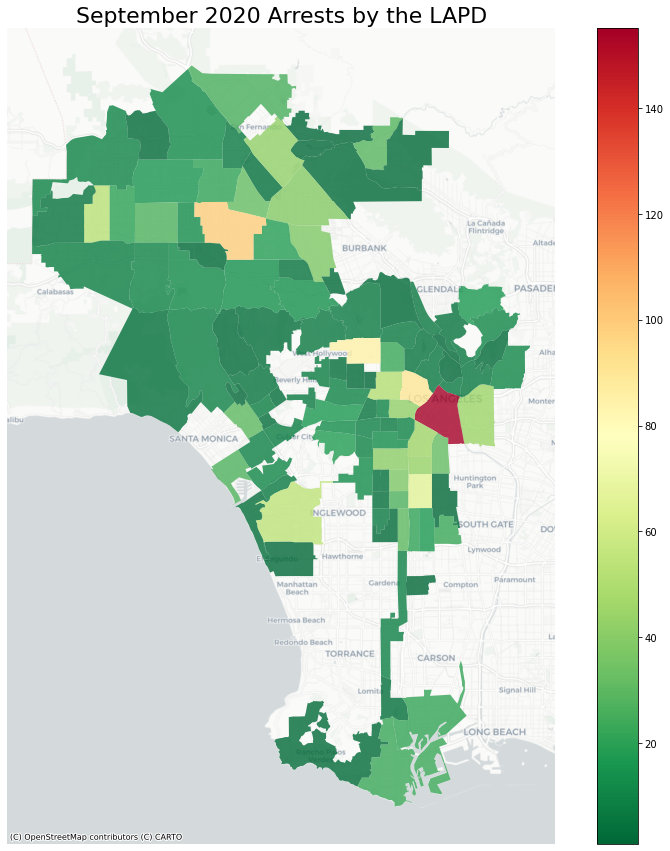

In [29]:
ax = neighborhoods.plot(figsize=(15,15),
                        column='crime_count',
                        legend=True,
                        alpha=0.8,
                        cmap='RdYlGn_r')

ax.axis('off')
ax.set_title('September 2020 Arrests by the LAPD',fontsize=22)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)